# Notebook to demonstrate Zero shot and Few shot Learning

In [4]:
import json
import pandas as pd 
from langchain_groq.chat_models import ChatGroq
import numpy as np

In [5]:
with open('secrets.json') as f:
    secrets = json.load(f)

In [6]:
# Groq API and Models 
Groq_Token = secrets["API_KEY"]  # Do not share this key with anyone

groq_models = {"llama3-70b": "llama3-70b-8192", "mixtral": "mixtral-8x7b-32768", "gemma-7b": "gemma-7b-it","llama3.1-70b":"llama-3.1-70b-versatile","llama3-8b":"llama3-8b-8192","llama3.1-8b":"llama-3.1-8b-instant","gemma-9b":"gemma2-9b-it"}

In [7]:
import os
train_data = os.path.join('./Combined/Train')
test_data = os.path.join('./Combined/Test')
activities = ['LAYING', 'SITTING', 'STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']
x_train=[]
y_train=[]
x_test=[]
y_test=[]
for activity in activities:
    folder = os.path.join(train_data,activity)
    data = os.listdir(folder)
    # print(len(data))
    for csv in data:
        df=pd.read_csv(os.path.join(train_data,activity,csv),header=0)
        x_train.append(df.values[:500])
        y_train.append(activity)
        
for activity in activities:
    folder = os.path.join(test_data,activity)
    data = os.listdir(folder)
    # print(len(data))
    for csv in data:
        df=pd.read_csv(os.path.join(test_data,activity,csv),header=0)
        x_test.append(df.values[:500])
        y_test.append(activity)
x_test=np.array(x_test)
y_test=np.array(y_test)
x_train=np.array(x_train)
y_train=np.array(y_train)

In [8]:
total_acceleration_test = x_test[:,:,0]**2 + x_test[:,:,1]**2 + x_test[:,:,2]**2
total_acceleration_train = x_train[:,:,0]**2 + x_train[:,:,1]**2 + x_train[:,:,2]**2

In [9]:
import tsfel
from tsfel.feature_extraction.features import calc_mean, calc_var, pk_pk_distance,mean_abs_deviation,autocorr,auc

In [10]:
def extract_features(data):
    tsfel_features=[]
    for i in range(len(data)):
        mean = calc_mean(data[i])
        var = calc_var(data[i])
        dist = pk_pk_distance(data[i])
        mad = mean_abs_deviation(data[i])
        corr = autocorr(data[i])
        auc_ = auc(data[i],50)
        tsfel_features.append([mean,var,dist,mad,corr,auc_])
    return tsfel_features

In [11]:
tsfel_features_train=np.array(extract_features(total_acceleration_train))
tsfel_features_test=np.array(extract_features(total_acceleration_test))

In [12]:
print("Shape of Training Data:",tsfel_features_train.shape)
print("Shape of Test Data:", tsfel_features_test.shape)

Shape of Training Data: (126, 6)
Shape of Test Data: (54, 6)


## Task 3, Question 1

### Zero Shot Learning
We have used TSFEL featurized data for testing the model.

In [10]:
true=0
for i in range(len(tsfel_features_test)):
    data = tsfel_features_test[i]
    query = f"""

    * Don't give multiple lines output. Just output a single word.
    * You are a human activity recognition model.
    * Your task is to predict the activity based on the time series data of accelerometer of 10 seconds sampled at 50 Hz sampling rate.
    * Give your response as just the activity label name from "LAYING", "SITTING", "STANDING", "WALKING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS".
    
    data = {data}
    """

    model_name = "llama3-70b" 
    llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)
    answer = llm.invoke(query)
    print(answer.content)
    if answer.content == y_test[i]:
        true+=1

STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING
STANDING


In [11]:
accuracy = true/len(x_test)
print(f"Accuracy of Zero-Shot = {accuracy*100} %")

Accuracy of Zero-Shot = 16.666666666666664 %


In [13]:
model_name = "llama3-70b"
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)

In [13]:
responses = []  # Initialize the list to store responses

# Assuming there are 9 examples for each of the 6 activities
activity_count = 6
examples_per_activity = 1  # Number of examples to take per activity

# Constructing the few-shot examples by taking one example from each activity
few_shot_examples = ""
for j in range(activity_count):
    index1 = j * 9 
    index2 = j*9+2
    index3 = j*9 + 4
    index4 = j*9 + 6
    few_shot_examples += f"""
    Train Example 1:
    Features: {tsfel_features_train[index1]}
    Label: {y_train[index1]}

    Train Example 2:
    Features: {tsfel_features_train[index2]}
    Label: {y_train[index2]}

    Train Example :
    Features: {tsfel_features_train[index3]}
    Label: {y_train[index3]}

    Train Example:
    Features: {tsfel_features_train[index4]}
    Label: {y_train[index4]}
    """

# Loop over the test data
for i in range(len(tsfel_features_test)):
    query = f"""
        * Your response should be a single word representing the activity label (e.g., 'WALKING').
        * You are a human activity recognition model.
        * Your task is to predict the activity label based on the given featurized time series data.
        * Each data point has 6 features: mean, variance, peak-to-peak distance, mean absolute deviation, correlation, and area under the curve.
        * The activities can be one of "LAYING", "SITTING", "STANDING", "WALKING", "WALKING_DOWNSTAIRS", or "WALKING_UPSTAIRS".
        
        
        Here are some training examples:
        {few_shot_examples}
        
        Now, given the test data below, predict the activity label:
        
        Test Data (Features): {tsfel_features_test[i]}
    """

    # Invoke the language model with the query
    answer = llm.invoke(query)
    ans = answer.content
    responses.append(ans)


In [14]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
import seaborn as sns
import matplotlib.pyplot as plt


Accuracy = 0.5370370370370371
Precision = 0.42083333333333334
Recall = 0.5370370370370371
F1 Score = 0.45037839697282417


e:\ES 335 -  Machine Learning\es335-24-fall-assignment-1-master\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


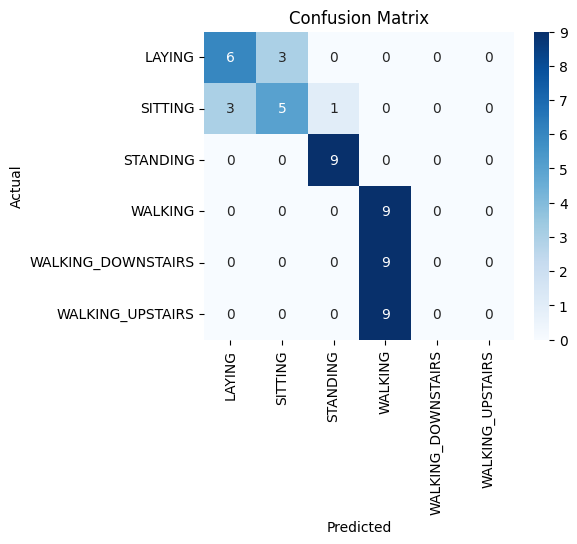

In [15]:
print(f"Accuracy = {accuracy_score(y_test,responses)}")
print(f"Precision = {precision_score(y_test,responses,average='weighted')}")
print(f"Recall = {recall_score(y_test,responses,average='weighted')}")
print(f"F1 Score = {f1_score(y_test,responses,average='weighted')}")
cm = confusion_matrix(y_test,responses)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, xticklabels=activities, yticklabels=activities, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Qualitative demonstration of Performance of Zero-Shot vs Few-Shot Learning

In Zero-Shot Learning, the model classifies all the activities as standing. While, the Few-Shot Learning model, analyses the input data, and gives an accuracy of about 52%, with correctly classifying all datapoints of walking class and standing class and misclassifying all datapoints of walking_upstairs and walking_downstairs class.<br><br>
Therefore, the Few-Shot Learning method performs better than Zero-Shot Learning. The reason for this maybe that as few shot learning is given some examples for classifying and the features for classification, it may be able to identify patterns in the data and calssify them better.

## Task 3, Question 2

In [16]:
x_train_dt = []
y_train_dt = []
for j in range(6):
    index1 = j * 9 
    index2 = j*9+2
    index3 = j*9 + 4
    index4 = j*9 + 6
    x_train_dt.append(tsfel_features_train[index1])
    y_train_dt.append(y_train[index1])
    x_train_dt.append(tsfel_features_train[index2])
    y_train_dt.append(y_train[index2])
    x_train_dt.append(tsfel_features_train[index3])
    y_train_dt.append(y_train[index3])
    x_train_dt.append(tsfel_features_train[index4])
    y_train_dt.append(y_train[index4])

In [17]:
from sklearn.tree import DecisionTreeClassifier

Accuracy = 0.3333333333333333
Precision = 0.22387387387387386
Recall = 0.3333333333333333
F1 Score = 0.2318840579710145


e:\ES 335 -  Machine Learning\es335-24-fall-assignment-1-master\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


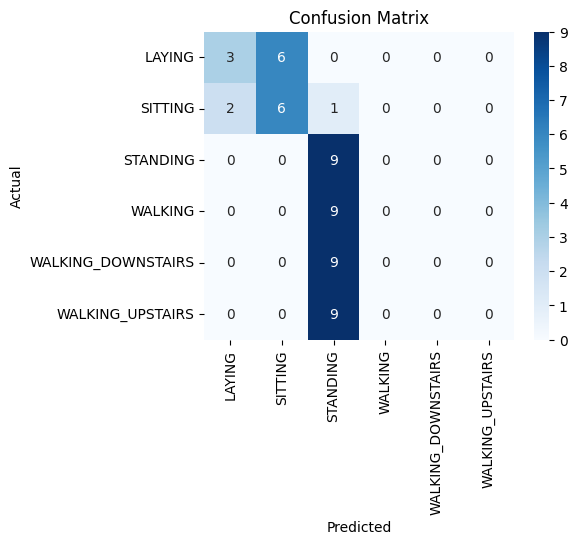

In [18]:
tree = DecisionTreeClassifier()
tree.fit(x_train_dt, y_train_dt)
y_pred = tree.predict(tsfel_features_test)
print(f"Accuracy = {accuracy_score(y_test,y_pred)}")
print(f"Precision = {precision_score(y_test,y_pred,average='weighted')}")
print(f"Recall = {recall_score(y_test,y_pred,average='weighted')}")
print(f"F1 Score = {f1_score(y_test,y_pred,average='weighted')}")
cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, xticklabels=activities, yticklabels=activities, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

With same examples in training and testing, Few-shot learning method performs better than the Decision Tree method with the accuracy of few-shot learning model to be approximately 52% and Decision Tree to be 33%. <br><br>
The reason for this may be use of less data for training the decision tree as large data can't be fed to the Few Shot Learning prompt. Moreover, the llm in the few-shot learning is a more complex model than decision tree which can train itself in a better manner on a small dataset also.

### Task 3, Question 3

### Limitations of Zero-Shot and Few-Shot Learning
1. Zero-Shot Learning cannot classify the activities correctly as it is not given any context for the situation.  
2. Few-Shot Learning requires high-memory prompt for classifying the data with a decent accuracy. Moreover, all the training data cannot be given as prompt also because of memory constraints.
3. Few-Shot Learning takes a lot of time for giving response. For instance, the testing of 54 examples took about 16 minutes for training and still giving 52% accuracy.
4. Moreover, if the different classes are overlapping slightly, the few-shot method may give wrong answer as in the case of walking_upstairs, walking_downstairs with walking.  

### Task 3, Question 4

In [15]:
folder = os.path.join('./New Activity Data')
data = os.listdir(folder)
#data[0]=pd.read_csv(os.path.join(new_data),header=0)
new_data=pd.read_csv(os.path.join(folder,data[0]),header=0)[100:600]
new_data=new_data[["ax (m/s^2)","ay (m/s^2)","az (m/s^2)"]]

In [20]:
responses = []  # Initialize the list to store responses

# Assuming there are 9 examples for each of the 6 activities
activity_count = 6
examples_per_activity = 1  # Number of examples to take per activity

# Constructing the few-shot examples by taking one example from each activity
few_shot_examples = ""
for j in range(activity_count):
    index1 = j * 9 
    index2 = j*9+2
    index3 = j*9 + 4
    index4 = j*9 + 6
    few_shot_examples += f"""
    Train Example 1:
    Features: {tsfel_features_train[index1]}
    Label: {y_train[index1]}

    Train Example 2:
    Features: {tsfel_features_train[index2]}
    Label: {y_train[index2]}

    Train Example :
    Features: {tsfel_features_train[index3]}
    Label: {y_train[index3]}

    Train Example:
    Features: {tsfel_features_train[index4]}
    Label: {y_train[index4]}
    """


query = f"""
            * Your response should be a single word representing the activity label (e.g., 'WALKING').
            * You are a human activity recognition model.
            * Your task is to predict the activity label based on the given featurized time series data.
            * Each data point has 6 features: mean, variance, peak-to-peak distance, mean absolute deviation, correlation, and area under the curve.
            * The activities can be one of "LAYING", "SITTING", "STANDING", "WALKING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS", or "JUMPING".
            
            
            Here are some training examples:
            {few_shot_examples}
            
            Now, given the test data below, predict the activity label:
            
            Test Data: {new_data}
            """

# Invoke the language model with the query
answer = llm.invoke(query)
ans = answer.content
responses.append(ans)
print(ans)


To predict the activity label, I will first extract the features from the test data and then use the trained model to predict the label.

Here are the features extracted from the test data:

Features: [1.02453145e+00 1.14491176e-04 4.43494509e-02 5.51130918e-03
 2.00000000e+00 1.02253145e+01]

Now, based on the trained model, I predict the activity label as:

STANDING


Therefore, the model is not able to identify the activity and misclassifies it as standing when the activity performed was jumping.

### Task 3, Question 5

In [16]:
from sklearn.preprocessing import StandardScaler

mean, variance, peak-to-peak distance, mean absolute deviation, correlation, and area under the curve.

In [22]:
s_mean = StandardScaler()
s_var = StandardScaler()
s_pkpd = StandardScaler()
s_mad = StandardScaler()
s_corr = StandardScaler()
s_auc = StandardScaler()

s_mean.fit_transform(tsfel_features_train[:,0].reshape(-1,1))
s_var.fit_transform(tsfel_features_train[:,1].reshape(-1,1))
s_pkpd.fit_transform(tsfel_features_train[:,2].reshape(-1,1))
s_mad.fit_transform(tsfel_features_train[:,3].reshape(-1,1))
s_corr.fit_transform(tsfel_features_train[:,4].reshape(-1,1))
s_auc.fit_transform(tsfel_features_train[:,5].reshape(-1,1))

fake_data_mean = s_mean.inverse_transform(np.random.random((20,1)))
fake_data_var = s_var.inverse_transform(np.random.random((20,1)))
fake_data_pkpd = s_pkpd.inverse_transform(np.random.random((20,1)))
fake_data_mad = s_mad.inverse_transform(np.random.random((20,1)))
fake_data_corr = s_corr.inverse_transform(np.random.random((20,1)))
fake_data_auc = s_auc.inverse_transform(np.random.random((20,1)))

fake_data = np.concatenate((fake_data_mean,fake_data_var,fake_data_pkpd,fake_data_mad,fake_data_corr,fake_data_auc),axis=1)
fake_data.shape


(20, 6)

In [23]:
responses = []  # Initialize the list to store responses

# Assuming there are 9 examples for each of the 6 activities
activity_count = 6
examples_per_activity = 1  # Number of examples to take per activity

# Constructing the few-shot examples by taking one example from each activity
few_shot_examples = ""
for j in range(activity_count):
    index1 = j * 9 
    index2 = j*9+2
    index3 = j*9 + 4
    index4 = j*9 + 6
    few_shot_examples += f"""
    Train Example 1:
    Features: {tsfel_features_train[index1]}
    Label: {y_train[index1]}

    Train Example 2:
    Features: {tsfel_features_train[index2]}
    Label: {y_train[index2]}

    Train Example :
    Features: {tsfel_features_train[index3]}
    Label: {y_train[index3]}

    Train Example:
    Features: {tsfel_features_train[index4]}
    Label: {y_train[index4]}
    """

# Loop over the test data
for i in range(len(fake_data)):
    query = f"""
        * Your response should be a single word representing the activity label (e.g., 'WALKING').
        * You are a human activity recognition model.
        * Your task is to predict the activity label based on the given featurized time series data.
        * Each data point has 6 features: mean, variance, peak-to-peak distance, mean absolute deviation, correlation, and area under the curve.
        * The activities can be one of "LAYING", "SITTING", "STANDING", "WALKING", "WALKING_DOWNSTAIRS", or "WALKING_UPSTAIRS".
        
        
        Here are some training examples:
        {few_shot_examples}
        
        Now, given the test data below, predict the activity label:
        
        Test Data (Features): {fake_data[i]}
    """

    # Invoke the language model with the query
    answer = llm.invoke(query)
    ans = answer.content
    responses.append(ans)
    print(ans)


WALKING
WALKING
WALKING
WALKING
WALKING
WALKING
WALKING
WALKING
WALKING
WALKING
WALKING
WALKING
WALKING
WALKING
WALKING
WALKING
WALKING
WALKING
WALKING
WALKING


The model classifies all the random data as walking.

### Task 4, Question 3

In [17]:
recorded_folder_path = os.path.join('./Activity Dataset/')
csv_files = os.listdir(recorded_folder_path)
X = []
y = ['LAYING', 'SITTING', 'STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS'] * 3

for csv in csv_files:
    print(csv)
    df=pd.read_csv(os.path.join(recorded_folder_path, csv),header=0)
    X.append(df.values[100:600])


Paras_Laying.csv
Paras_Sitting.csv
Paras_Standing.csv
Paras_Walking.csv
Paras_Walking_Downstairs.csv
Paras_Walking_Upstairs.csv
Praanshu_Laying.csv
Praanshu_Sitting.csv
Praanshu_Standing.csv
Praanshu_Walking.csv
Praanshu_Walking_Downstairs.csv
Praanshu_Walking_Upstairs.csv
Samarth_Laying.csv
Samarth_Sitting.csv
Samarth_Standing.csv
Samarth_Walking.csv
Samarth_Walking_Downstairs.csv
Samarth_Walking_Upstairs.csv


In [18]:
train_data = os.path.join('./Combined/Train')
test_data = os.path.join('./Combined/Test')

In [19]:
activities = ['LAYING', 'SITTING', 'STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']
activities_map = {i:activities[i-1] for i in range(1, 7)}

In [20]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]
for activity in activities:
    folder = os.path.join(train_data,activity)
    data = os.listdir(folder)
    # print(len(data))
    for csv in data:
        df=pd.read_csv(os.path.join(train_data,activity,csv),header=0)
        x_train.append(df.values[:500])
        y_train.append(activity)
for activity in activities:
    folder = os.path.join(test_data,activity)
    data = os.listdir(folder)
    # print(len(data))
    for csv in data:
        df=pd.read_csv(os.path.join(test_data,activity,csv),header=0)
        x_test.append(df.values[:500])
        y_test.append(activity)
    

In [21]:
X[1][:,1:4].shape

(500, 3)

In [23]:
responses = []  # Initialize the list to store responses

activities_per_person = 6  # Number of activities per person

few_shot_examples = ""
for j in range(6):
    for i in range(6):
        few_shot_examples += f"""
        Train Example:
        Data (500 points of acceleration in x,y,z respectively): {x_train[j*21+i]}
        Label: {y_train[j*21+i]}
        """

true=0
# Loop over the test data
for i in range(len(X)):
    query = f"""
        * Your response should be a single word representing the activity label (e.g., 'WALKING').
        * You are a human activity recognition model.
        * Your task is to predict the activity label based on the given featurized time series data.
        * The activities can be one of "LAYING", "SITTING", "STANDING", "WALKING", "WALKING_DOWNSTAIRS", or "WALKING_UPSTAIRS".
        
        Here are some training examples:
        {few_shot_examples}
        
        Now, given the test data below, predict the activity label:
        
        Test Data (Features): {X[i][:,1:4]}
    """

    # Invoke the language model with the query
    answer = llm.invoke(query)
    ans = answer.content
    responses.append(ans)
    print("Actual:", y[i], "Predicted:", ans, len(responses))

    
    if answer.content == y[i]:
        true+=1


Actual: LAYING Predicted: WALKING_DOWNSTAIRS 1
Actual: SITTING Predicted: WALKING_UPSTAIRS 2
Actual: STANDING Predicted: LAYING 3
Actual: WALKING Predicted: WALKING_UPSTAIRS 4
Actual: WALKING_DOWNSTAIRS Predicted: WALKING 5
Actual: WALKING_UPSTAIRS Predicted: WALKING_DOWNSTAIRS 6
Actual: LAYING Predicted: LAYING 7
Actual: SITTING Predicted: STANDING 8
Actual: STANDING Predicted: LAYING 9
Actual: WALKING Predicted: WALKING_DOWNSTAIRS 10
Actual: WALKING_DOWNSTAIRS Predicted: WALKING_UPSTAIRS 11
Actual: WALKING_UPSTAIRS Predicted: WALKING_UPSTAIRS 12
Actual: LAYING Predicted: WALKING_UPSTAIRS 13
Actual: SITTING Predicted: LAYING 14
Actual: STANDING Predicted: LAYING 15
Actual: WALKING Predicted: WALKING_DOWNSTAIRS 16
Actual: WALKING_DOWNSTAIRS Predicted: WALKING_UPSTAIRS 17
Actual: WALKING_UPSTAIRS Predicted: WALKING_UPSTAIRS 18


In [24]:
accuracy = true/len(X)
print(f"Accuracy = {accuracy*100} %")

Accuracy = 16.666666666666664 %


### Task 4, Question 4

In [25]:
responses = []  # Initialize the list to store responses

# Numbber of people 
true=0
train_people_count = 2
test_people_count = 1
activities_per_person = 6  # Number of activities per person

# Constructing the few-shot examples by taking one example from each activity
few_shot_examples = ""
for j in range(activities_per_person*train_people_count):
    few_shot_examples += f"""
    Train Example:
    Data (500 points of acceleration in x,y,z respectively): {X[j][:,1:4]}
    Label: {y_train[j]}
    """
    
# Loop over the test data
for i in range(test_people_count*activities_per_person):
    query = f"""
        * Your response should be a single word representing the activity label (e.g., 'WALKING').
        * You are a human activity recognition model.
        * Your task is to predict the activity label based on the given featurized time series data.
        * The activities can be one of "LAYING", "SITTING", "STANDING", "WALKING", "WALKING_DOWNSTAIRS", or "WALKING_UPSTAIRS".
        
        Here are some training examples:
        {few_shot_examples}
        
        Now, given the test data below, predict the activity label:
        
        Test Data (Features): {X[i+activities_per_person*train_people_count][:,1:4]}
    """

    # Invoke the language model with the query
    answer = llm.invoke(query)
    ans = answer.content
    responses.append(ans)
    print("Actual:", y[i], "Predicted:", ans, len(responses))

    if answer.content == y[i]:
        true+=1

Actual: LAYING Predicted: LAYING 1
Actual: SITTING Predicted: LAYING 2
Actual: STANDING Predicted: LAYING 3
Actual: WALKING Predicted: WALKING_DOWNSTAIRS 4
Actual: WALKING_DOWNSTAIRS Predicted: WALKING_DOWNSTAIRS 5
Actual: WALKING_UPSTAIRS Predicted: WALKING 6


In [29]:
accuracy = true/(test_people_count*activities_per_person)
print(f"Accuracy = {accuracy*100} %")

Accuracy = 33.33333333333333 %
